In [1]:
#import libraries
import os
import shutil
import random
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-04-08 13:43:31.201993: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:

# import zipfile
# # 原压缩文件在服务器的位置
# # 这里的第二个参数用r表示是读取zip文件，w或a是创建一个zip文件
# f = zipfile.ZipFile("TNB_split.zip",'r') 
# # f.namelist() 会返回压缩包内所有文件名的列表
# for file in f.namelist():
#   f.extract(file,"./") #解压到的位置，./表示当前目录(与此.ipynb文件同一个目录)
# f.close()

In [3]:
# import os
# import tarfile

# def recursive_files(dir_name='.', ignore=None):
#     for dir_name,subdirs,files in os.walk(dir_name):
#         if ignore and os.path.basename(dir_name) in ignore: 
#             continue

#         for file_name in files:
#             if ignore and file_name in ignore:
#                 continue

#             yield os.path.join(dir_name, file_name)

# def make_tar_file(dir_name='.', tar_file_name='tarfile.tar', ignore=None):
#     tar = tarfile.open(tar_file_name, 'w')

#     for file_name in recursive_files(dir_name, ignore):
#         tar.add(file_name)

#     tar.close()


# dir_name = 'TNB_split'
# tar_file_name = 'antime_py.tar'
# ignore = {'.ipynb_checkpoints', '__pycache__', tar_file_name}
# make_tar_file(dir_name, tar_file_name, ignore)

In [4]:
# # 定义主目录和子目录
# main_dir = "TNB"
# train_dir = 'train'
# test_dir = 'test'
# val_dir = 'val'

In [5]:
# # 创建目录
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

In [6]:
# # 定义划分比例
# train_ratio = 0.7
# test_ratio = 0.2
# val_ratio = 0.1

In [7]:
# # 遍历主目录下的子目录（类别）
# for subdir in os.listdir(main_dir):
#     subdir_path = os.path.join(main_dir, subdir)
#     if os.path.isdir(subdir_path):
#         # 创建类别对应的目录
#         os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
#         os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)
#         os.makedirs(os.path.join(val_dir, subdir), exist_ok=True)
        
#         # 获取类别下的所有图像文件
#         images = [f for f in os.listdir(subdir_path) if f.endswith('.jpg') or f.endswith('.png')]
#         num_images = len(images)
        
#         # 随机打乱图像文件列表
#         random.shuffle(images)
        
#         # 计算划分数量
#         train_split = int(train_ratio * num_images)
#         test_split = int(test_ratio * num_images)
        
#         # 划分图像文件并拷贝到对应目录
#         train_images = images[:train_split]
#         test_images = images[train_split:train_split + test_split]
#         val_images = images[train_split + test_split:]
        
#         for img in train_images:
#             src = os.path.join(subdir_path, img)
#             dst = os.path.join(train_dir, subdir, img)
#             shutil.copyfile(src, dst)
            
#         for img in test_images:
#             src = os.path.join(subdir_path, img)
#             dst = os.path.join(test_dir, subdir, img)
#             shutil.copyfile(src, dst)
            
#         for img in val_images:
#             src = os.path.join(subdir_path, img)
#             dst = os.path.join(val_dir, subdir, img)
#             shutil.copyfile(src, dst)


In [8]:
# Data preparation
dataset_dir= 'TNB_split'
input_shape=(224, 224, 3)
batch_size=8
num_classes=5

In [9]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen=ImageDataGenerator(
    rescale=1./255)

In [10]:
# # 获取生成器的类别索引
# class_indices = train_generator.class_indices

# # 删除 .ipynb_checkpoints 类别
# class_indices.pop('.ipynb_checkpoints', None)

In [11]:
#Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical', #skin has two classes: benign and malignant
    )

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical', #skin has two classes: benign and malignant
    )

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical', #skin has two classes: benign and malignant
    )

Found 2562 images belonging to 5 classes.
Found 369 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [12]:
# load pre-trained VGG model without the top layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-04-08 13:43:33.269287: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-04-08 13:43:33.307217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:e3:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.55GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2024-04-08 13:43:33.307252: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-04-08 13:43:33.311285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-04-08 13:43:33.311355: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-04-08 13:43:33.312658: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [13]:
# Freeze the pre-trained layers so they are not updated during training
for layer in vgg16.layers:
    layer.trainable = False

In [14]:
# create a new model and add the VGG base model
model = Sequential()
model.add(vgg16)

In [15]:
# Add additional layers for classification
model.add(Flatten())
model.add(Dense(256, activation='relu'))  # first FC layer
model.add(Dense(5, activation='softmax'))  # second FC layer

In [16]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 21,138,757
Trainable params: 6,424,069
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
#Train the model
history=model.fit(train_generator, epochs=50, validation_data=(validation_generator), verbose=1)

Epoch 1/50


2024-04-08 13:43:35.011963: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-04-08 13:43:35.012495: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000000000 Hz
2024-04-08 13:43:46.155460: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-04-08 13:43:47.007228: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2024-04-08 13:43:48.023522: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-04-08 13:43:48.023544: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at /usr/local/cuda-11.2/bin/ptxas
2024-04-08 13:43:48.023622: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: /usr/local/cuda-11.2/bin/ptxas ptxas too old. Falling back to the driver to compile.
Re

  3/321 [..............................] - ETA: 24s - loss: 3.9709 - accuracy: 0.2569    

2024-04-08 13:43:49.068076: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


321/321 [==============================] - 62s 148ms/step - loss: 1.5740 - accuracy: 0.6102 - val_loss: 0.8301 - val_accuracy: 0.7073
Epoch 2/50
321/321 [==============================] - 47s 147ms/step - loss: 0.8162 - accuracy: 0.7014 - val_loss: 0.7991 - val_accuracy: 0.7317
Epoch 3/50
321/321 [==============================] - 48s 149ms/step - loss: 0.7974 - accuracy: 0.7151 - val_loss: 0.8369 - val_accuracy: 0.6911
Epoch 4/50
321/321 [==============================] - 46s 143ms/step - loss: 0.7869 - accuracy: 0.7128 - val_loss: 0.7308 - val_accuracy: 0.6911
Epoch 5/50
321/321 [==============================] - 46s 144ms/step - loss: 0.7543 - accuracy: 0.7202 - val_loss: 0.7920 - val_accuracy: 0.6992
Epoch 6/50
321/321 [==============================] - 47s 147ms/step - loss: 0.7635 - accuracy: 0.7168 - val_loss: 0.8021 - val_accuracy: 0.6775
Epoch 7/50
321/321 [==============================] - 47s 147ms/step - loss: 0.7079 - accuracy: 0.7447 - val_loss: 0.7334 - val_accuracy: 0.7

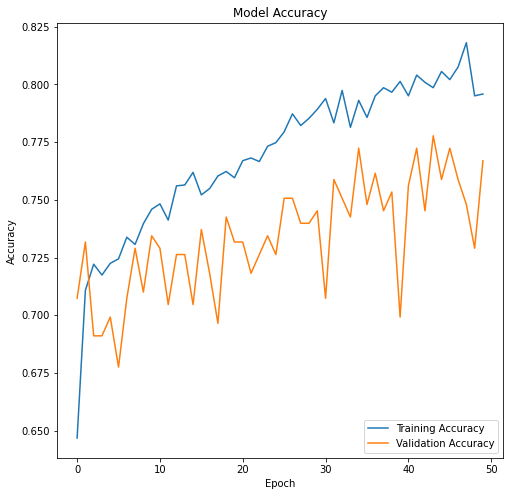

In [19]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

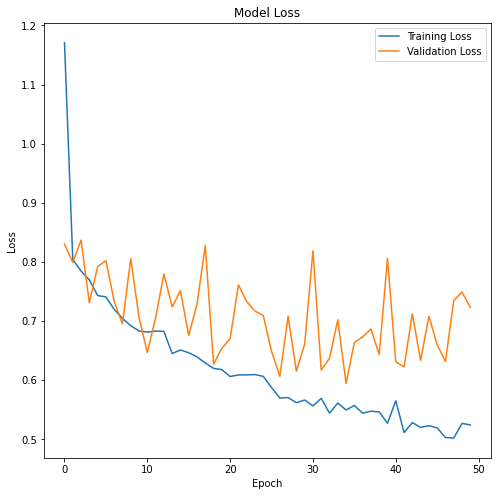

In [20]:
#Trainig loss and validation loss graph
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [21]:
# Evaluate the model on the testing dataset
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

92/92 [==============================] - 5s 51ms/step - loss: 0.7997 - accuracy: 0.7319
Test loss: 0.7997128367424011
Test accuracy: 0.7318741679191589


In [22]:
# import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

In [23]:
# Get the prediction results of the model
y_pred = model.predict(test_generator)
y_true = test_generator.classes

Confusion Matrix:
[[  1  62   5   2   4]
 [  1 186   8   3   1]
 [  1  30 330   0   0]
 [  0  45   0   8   6]
 [  0  27   0   1  10]]


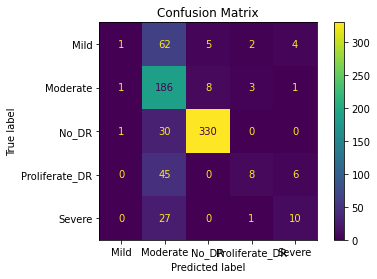

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert probabilities to categories
y_pred_labels = np.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_labels)

print("Confusion Matrix:")
print(confusion)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

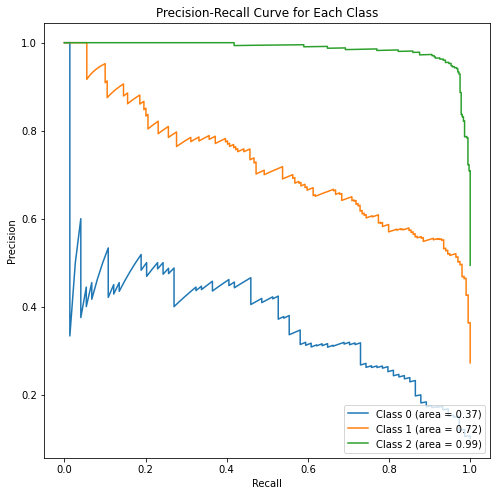

In [25]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize multi-category labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # 0, 1, 2是你的类别标签

#Initialize drawing
plt.figure(figsize=(8, 8))

# Calculate precision-recall curve for each category
for i in range(y_true_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label='Class {} (area = {:0.2f})'.format(i, pr_auc))

# Draw legends, labels, etc.
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

In [26]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

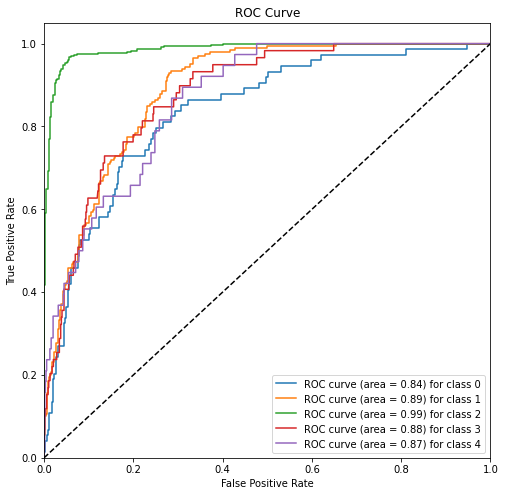

In [27]:
# Plot ROC curve
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [28]:
# Import necessary libraries
from sklearn.metrics import f1_score

# Assuming y_true and y_pred_labels are defined

# Compute the F1 score (micro)
f1_micro = f1_score(y_true, y_pred_labels, average='micro')
print('F1-score (micro):', f1_micro)

# Compute the F1 score (macro)
f1_macro = f1_score(y_true, y_pred_labels, average='macro')
print('F1-score (macro):', f1_macro)

# Compute the F1 score (weighted)
f1_weighted = f1_score(y_true, y_pred_labels, average='weighted')
print('F1-score (weighted):', f1_weighted)

F1-score (micro): 0.7318741450068399
F1-score (macro): 0.439846157485713
F1-score (weighted): 0.6853816289442424


In [29]:

# Initialize variables to store overall sensitivity and specificity
overall_sensitivity = 0
overall_specificity = 0

# Loop through each class
for i, class_label in enumerate(class_labels):
    # Extract TP, FP, FN, and TN for the current class
    TP = confusion[i, i]
    FP = sum(confusion[:, i]) - TP
    FN = sum(confusion[i, :]) - TP
    TN = sum(sum(confusion)) - TP - FP - FN
    
    # Compute sensitivity and specificity for the current class
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    # Print or store sensitivity and specificity for the current class
    print(f'Class {class_label} Sensitivity: {sensitivity:.4f}')
    print(f'Class {class_label} Specificity: {specificity:.4f}')
    
    # Accumulate sensitivity and specificity for overall calculation
    overall_sensitivity += sensitivity
    overall_specificity += specificity

# Calculate overall sensitivity and specificity
num_classes = len(class_labels)
overall_sensitivity /= num_classes
overall_specificity /= num_classes

# Print or store overall sensitivity and specificity
print(f'Overall Sensitivity: {overall_sensitivity:.4f}')
print(f'Overall Specificity: {overall_specificity:.4f}')


Class Mild Sensitivity: 0.0135
Class Mild Specificity: 0.9970
Class Moderate Sensitivity: 0.9347
Class Moderate Specificity: 0.6917
Class No_DR Sensitivity: 0.9141
Class No_DR Specificity: 0.9649
Class Proliferate_DR Sensitivity: 0.1356
Class Proliferate_DR Specificity: 0.9911
Class Severe Sensitivity: 0.2632
Class Severe Specificity: 0.9841
Overall Sensitivity: 0.4522
Overall Specificity: 0.9257


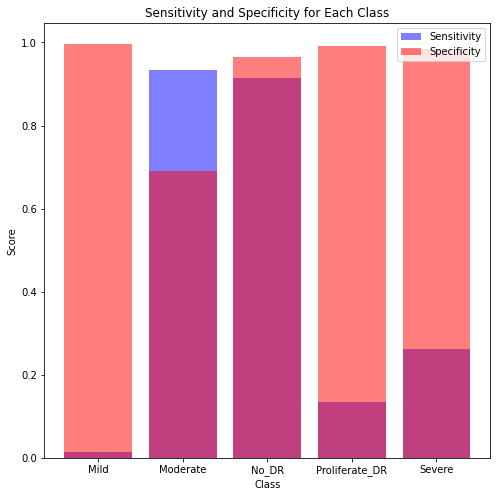

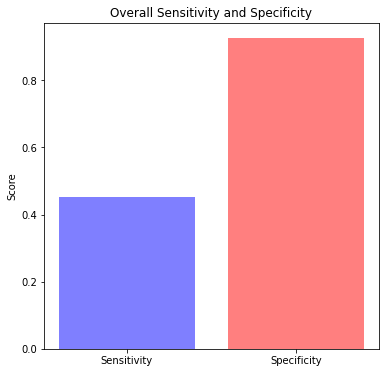

In [30]:
import matplotlib.pyplot as plt

# Initialize variables to store overall sensitivity and specificity
overall_sensitivity = 0
overall_specificity = 0
sensitivity_scores = []
specificity_scores = []

# Loop through each class
for i, class_label in enumerate(class_labels):
    # Extract TP, FP, FN, and TN for the current class
    TP = confusion[i, i]
    FP = sum(confusion[:, i]) - TP
    FN = sum(confusion[i, :]) - TP
    TN = sum(sum(confusion)) - TP - FP - FN
    
    # Compute sensitivity and specificity for the current class
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    # Accumulate sensitivity and specificity for overall calculation
    overall_sensitivity += sensitivity
    overall_specificity += specificity
    
    # Store sensitivity and specificity for current class
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

# Calculate overall sensitivity and specificity
num_classes = len(class_labels)
overall_sensitivity /= num_classes
overall_specificity /= num_classes

# Plotting sensitivity and specificity for each class
plt.figure(figsize=(8, 8))
plt.bar(range(len(class_labels)), sensitivity_scores, color='b', alpha=0.5, label='Sensitivity')
plt.bar(range(len(class_labels)), specificity_scores, color='r', alpha=0.5, label='Specificity')
plt.xticks(range(len(class_labels)), class_labels)
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity for Each Class')
plt.legend()
plt.show()

# Plotting overall sensitivity and specificity
plt.figure(figsize=(6, 6))
plt.bar(['Sensitivity', 'Specificity'], [overall_sensitivity, overall_specificity], color=['b', 'r'], alpha=0.5)
plt.ylabel('Score')
plt.title('Overall Sensitivity and Specificity')
plt.show()


In [31]:
from keras import backend as K
import gc

In [32]:
K.clear_session()
gc.collect()


13593

In [33]:
del model

In [34]:
# you will need to install numba using "pip install numba"
from numba import cuda

ModuleNotFoundError: No module named 'numba'

In [ ]:
cuda.select_device(0)
cuda.close()